In [79]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from arch import arch_model
import datetime
from scipy.stats import kurtosis, skew, norm

start = '2019-01-01'
end = '2024-11-08'

XOM_data = yf.download('XOM', start=start, end=end)
JPM_data = yf.download('JPM', start=start, end=end)
MCD_data = yf.download('MCD', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
price_data = pd.concat([XOM_data['Adj Close'], JPM_data['Adj Close'], MCD_data['Adj Close']], axis=1)
price_data.columns = ['XOM', 'JPM', 'MCD']
price_data

,XOM,JPM,MCD
Date,,,
2019-01-02,52.182484,83.344444,153.119019
2019-01-03,51.381298,82.159988,152.110153
2019-01-04,53.275711,85.188835,155.049713
2019-01-07,53.552753,85.248077,156.737015
2019-01-08,53.942123,85.087303,157.067459
...,...,...,...
2024-11-01,114.013138,222.940002,293.444763
2024-11-04,117.643311,219.779999,291.098907
2024-11-05,117.990456,221.490005,295.542175


In [31]:
daily_returns = price_data.pct_change().dropna()
daily_returns

,XOM,JPM,MCD
Date,,,
2019-01-03,-0.015354,-0.014212,-0.006589
2019-01-04,0.036870,0.036865,0.019325
2019-01-07,0.005200,0.000695,0.010882
2019-01-08,0.007271,-0.001886,0.002108
2019-01-09,0.005275,-0.001690,-0.001717
...,...,...,...
2024-11-01,-0.015671,0.004596,0.010612
2024-11-04,0.031840,-0.014174,-0.007994
2024-11-05,0.002951,0.007781,0.015264


In [35]:
def sharpe_simulation(tickers, n_sims, start=None, end=None):
    if start is None:
        start = datetime.datetime.today() - datetime.timedelta(365*5)
        
    stock_data = yf.download(tickers, start, end)
    adj_close = stock_data['Adj Close']
    stock_ret = adj_close.pct_change()
    
    port_wts = []
    port_ann_rets = [] 
    port_risks = []
    port_sharpe_rts = []
    
    for i in range(n_sims):
        n = len(tickers)
        alpha = np.ones(n)
        weights = np.random.dirichlet(alpha)
        weights = np.expand_dims(weights, axis=1)
        
        port_rets = stock_ret.dot(weights)
        total_ret = (port_rets+1).prod() - 1
        n_years = (port_rets.index.max() - port_rets.index.min()).days / 365
        ann_ret = (total_ret+1)**(1/n_years) - 1
        port_sd = port_rets.std()*np.sqrt(250)
        
        port_wts.append(weights)
        port_ann_rets.append(ann_ret)
        port_risks.append(port_sd)
    
    return np.array(port_wts), np.array(port_risks), np.array(port_ann_rets)

In [42]:
tickers = ['XOM', 'JPM', 'MCD']
bond_data = yf.download('^TNX')
rfr = bond_data['Close'].iloc[-1] / 100
port_wts, port_risks, port_ann_rets = sharpe_simulation(tickers, n_sims=10000)

[*********************100%%**********************]  3 of 3 completed


Text(0, 0.5, 'Portflio return')

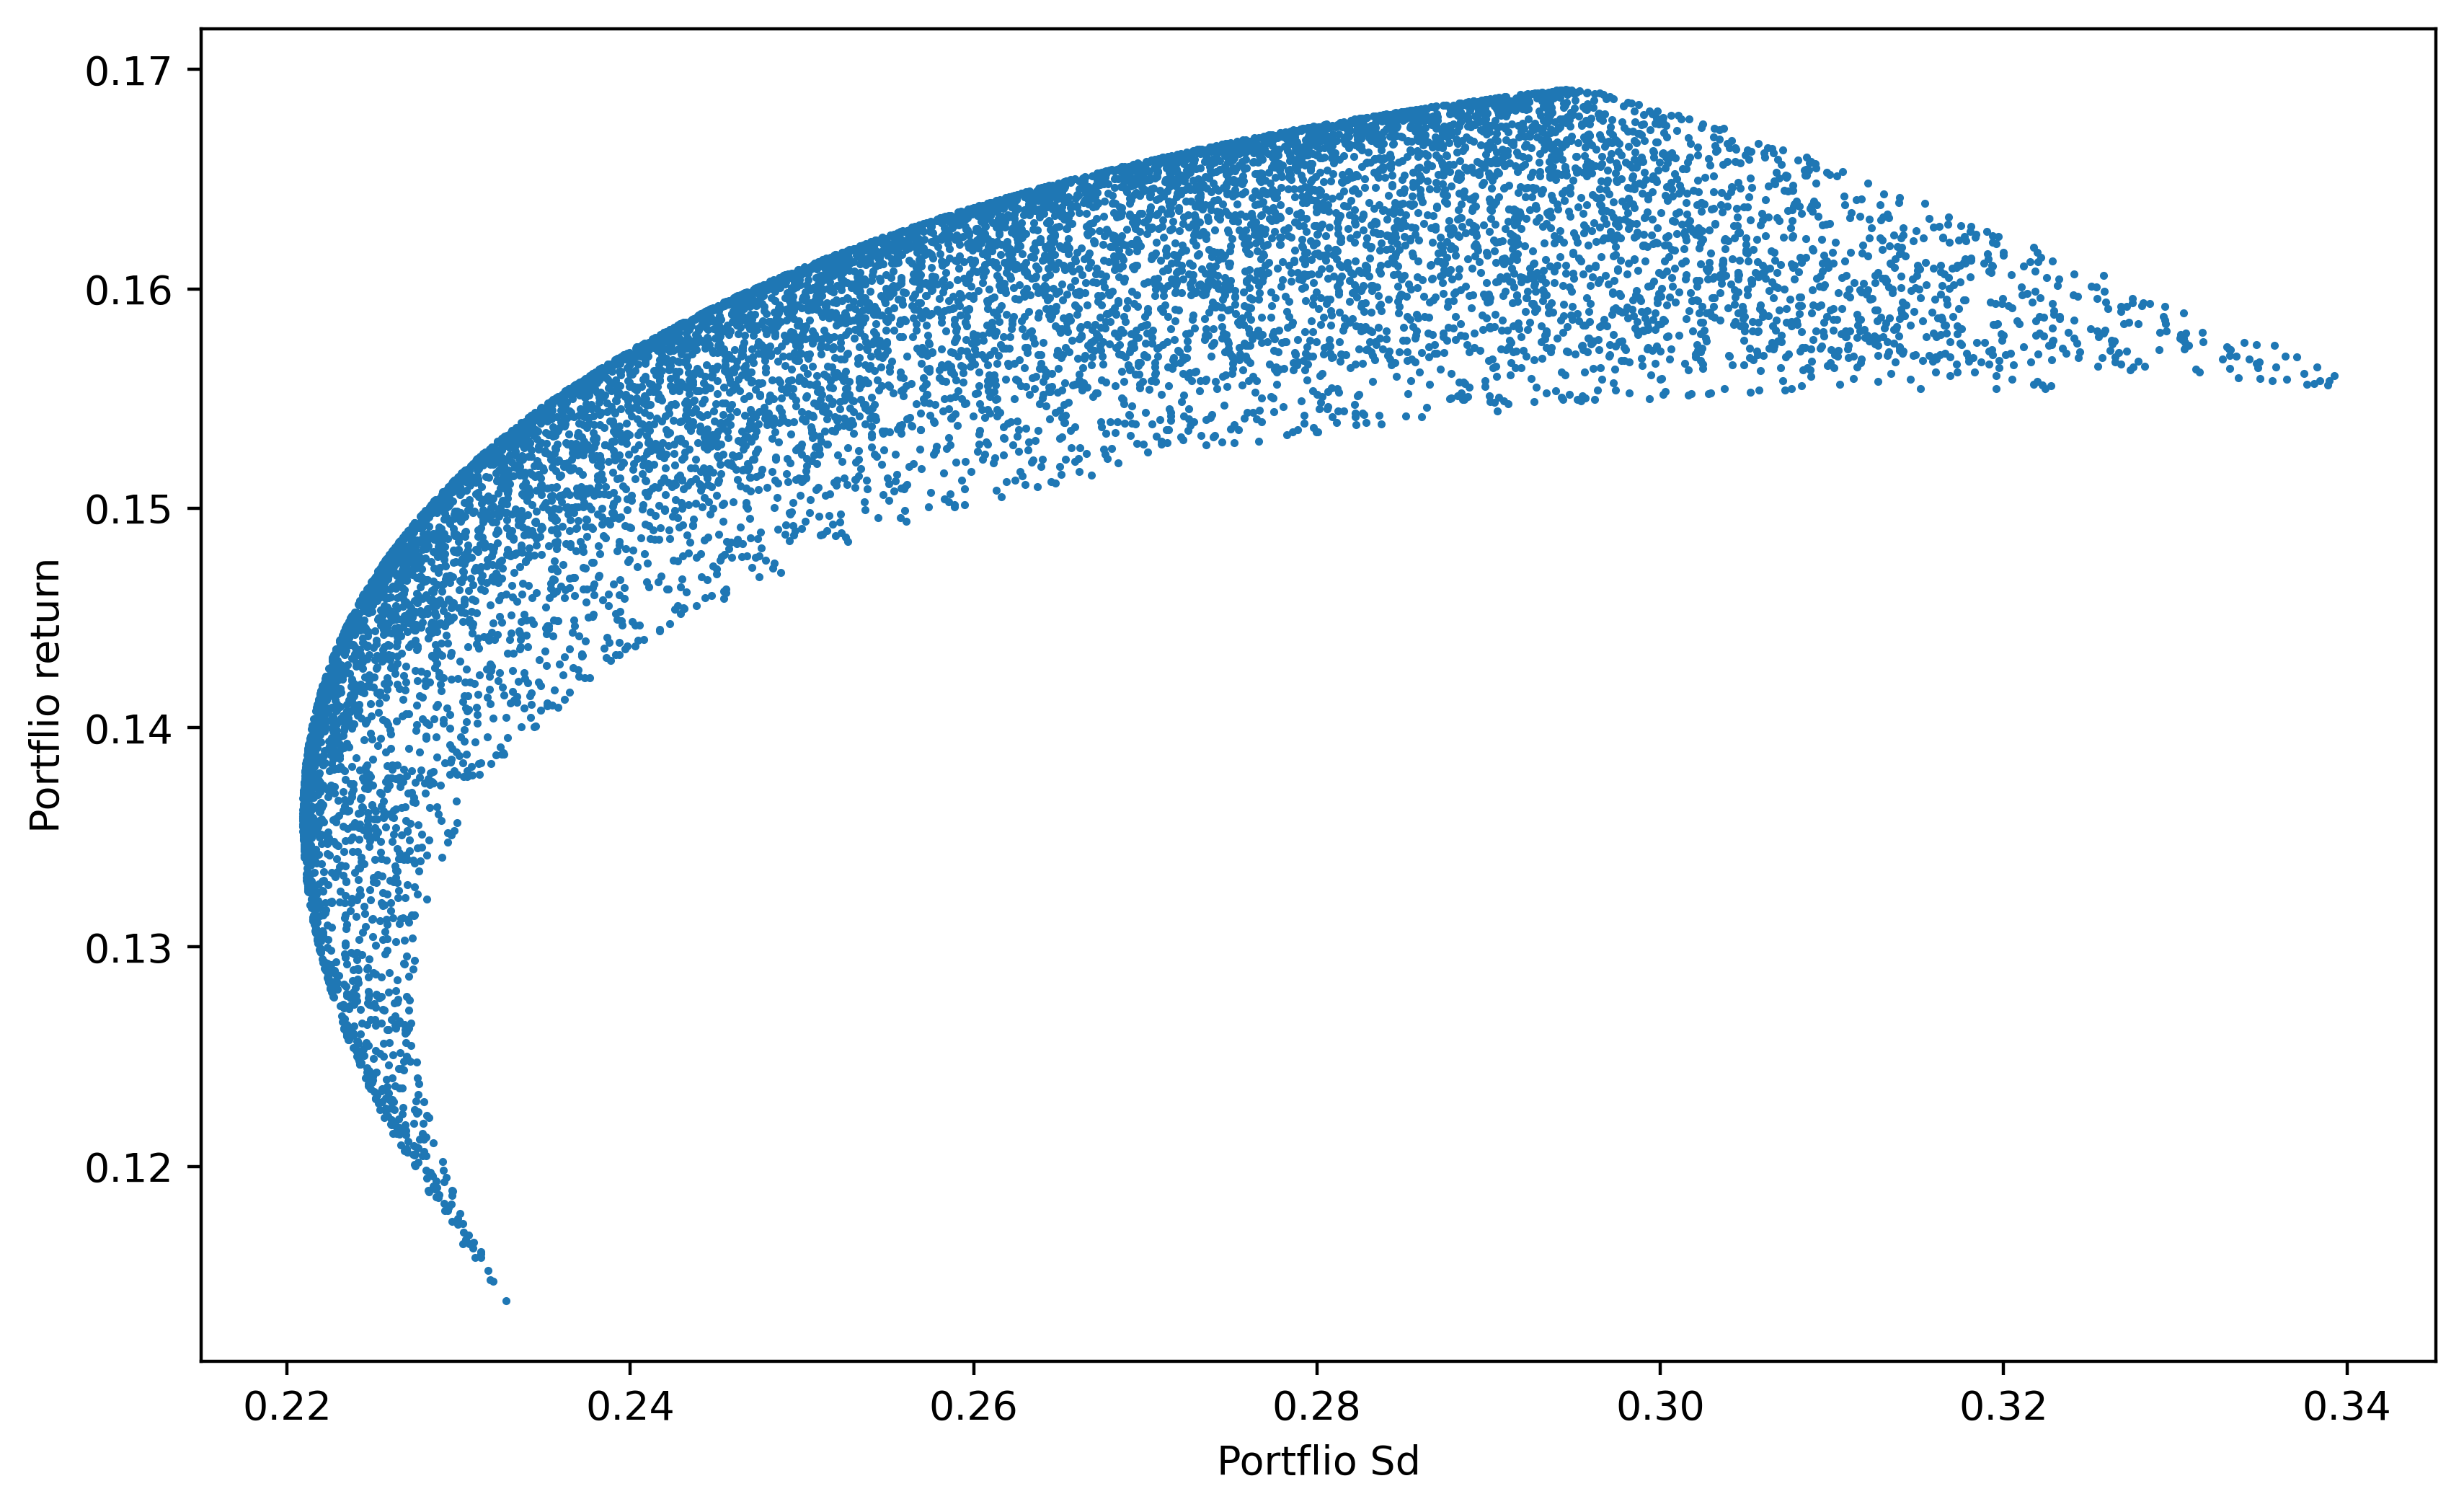

In [83]:
plt.figure(figsize=(10,6), dpi = 400)
plt.scatter(port_risks, port_ann_rets, s = 1)
plt.xlabel('Portflio Sd')
plt.ylabel('Portflio return')

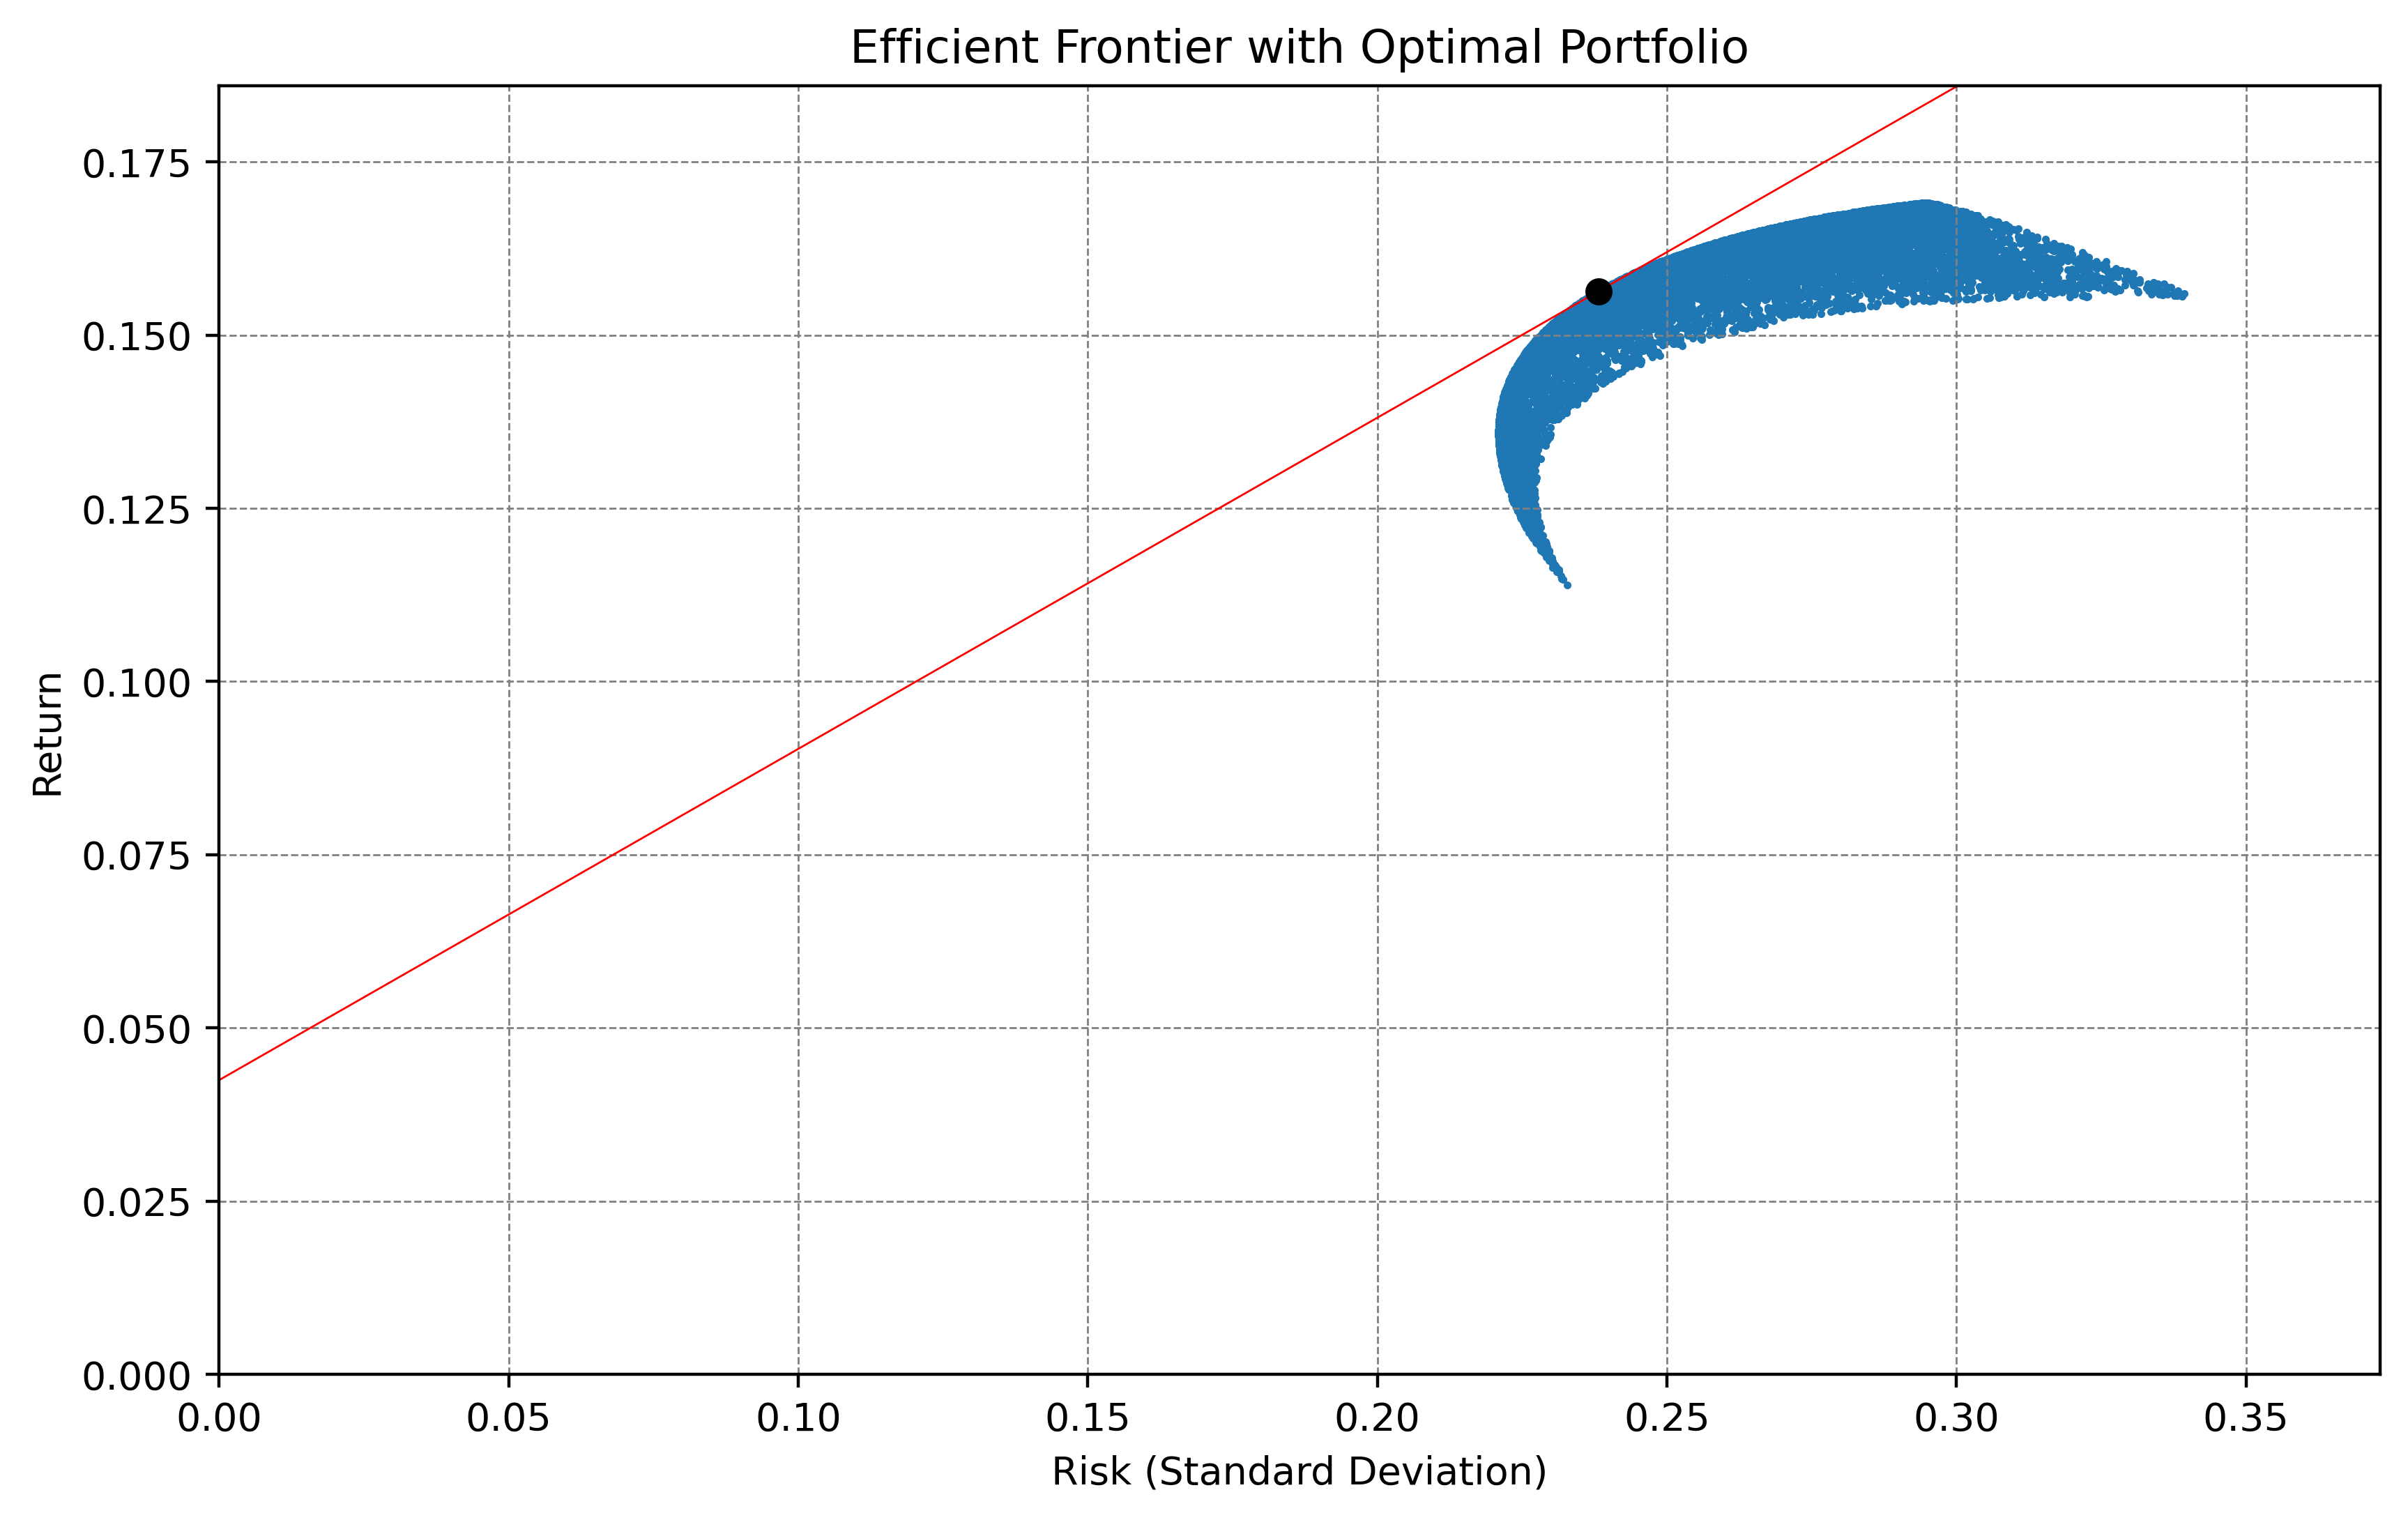

In [150]:
slopes = (port_ann_rets - rfr) / port_risks
max_slope_index = np.argmax(np.abs(slopes))
P2 = (port_risks[max_slope_index], port_ann_rets[max_slope_index])

m = (P2[1] - rfr) / P2[0]
c = rfr

def line(x):
    return m * x + c

x_values = np.linspace(0, max(port_risks), 100)
y_values = line(x_values)

plt.figure(figsize=(10,6), dpi = 400)
plt.scatter(port_risks, port_ann_rets, s = 1, label='Portfolios')
plt.plot(x_values, y_values, color='red', linewidth=0.5, label='Steepest Line')
plt.scatter(*P2, color='black', zorder=5, label='Steepest Point')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xlim(0, max(port_risks) + 0.1 * max(port_risks))
plt.ylim(0, max(port_ann_rets) + 0.1 * max(port_ann_rets))
plt.title('Efficient Frontier with Optimal Portfolio')
plt.show()

In [51]:
print('\033[1mOptimal Portfolio\033[0m')
print('weights:')
for i, tick in enumerate(tickers):
    print(f'{tick} {np.around(port_wts[max_slope_index][i][0], 3)}')

Optimal Portfolio
weights:
XOM 0.273
JPM 0.403
MCD 0.325


In [87]:
weights = np.array([0.273, 0.403, 0.325]) 

mean_returns = daily_returns.mean()
std_dev = daily_returns.std()
kurt = daily_returns.apply(kurtosis)
skewness = daily_returns.apply(skew)

portfolio_return = np.dot(mean_returns, weights)
portfolio_variance = np.dot(weights.T, np.dot(daily_returns.cov(), weights))
portfolio_std_dev = np.sqrt(portfolio_variance)

portfolio_kurt = kurtosis(np.dot(daily_returns, weights))
portfolio_skew = skew(np.dot(daily_returns, weights))

summary_statistics = {
    'Mean Return': pd.concat([mean_returns, pd.Series([portfolio_return], index=['Portfolio'])]),
    'Std Dev': pd.concat([std_dev, pd.Series([portfolio_std_dev], index=['Portfolio'])]),
    'Kurtosis': pd.concat([kurt, pd.Series([portfolio_kurt], index=['Portfolio'])]),
    'Skewness': pd.concat([skewness, pd.Series([portfolio_skew], index=['Portfolio'])])}

summary_statistics_table = pd.DataFrame(summary_statistics)
summary_statistics_table

,Mean Return,Std Dev,Kurtosis,Skewness
XOM,0.000776,0.020500,5.077240,0.048647
JPM,0.000897,0.019476,13.700840,0.439479
MCD,0.000540,0.014115,34.835147,0.373299
Portfolio,0.000749,0.014787,17.700404,-0.196980


In [57]:
portfolio_returns = daily_returns.dot(weights)
portfolio_returns

Date
2019-01-03   -0.012060
2019-01-04    0.031203
2019-01-07    0.005237
2019-01-08    0.001910
2019-01-09    0.000201
                ...   
2024-11-01    0.001023
2024-11-04    0.000382
2024-11-05    0.008902
2024-11-06    0.047577
2024-11-07   -0.016353
Length: 1473, dtype: float64

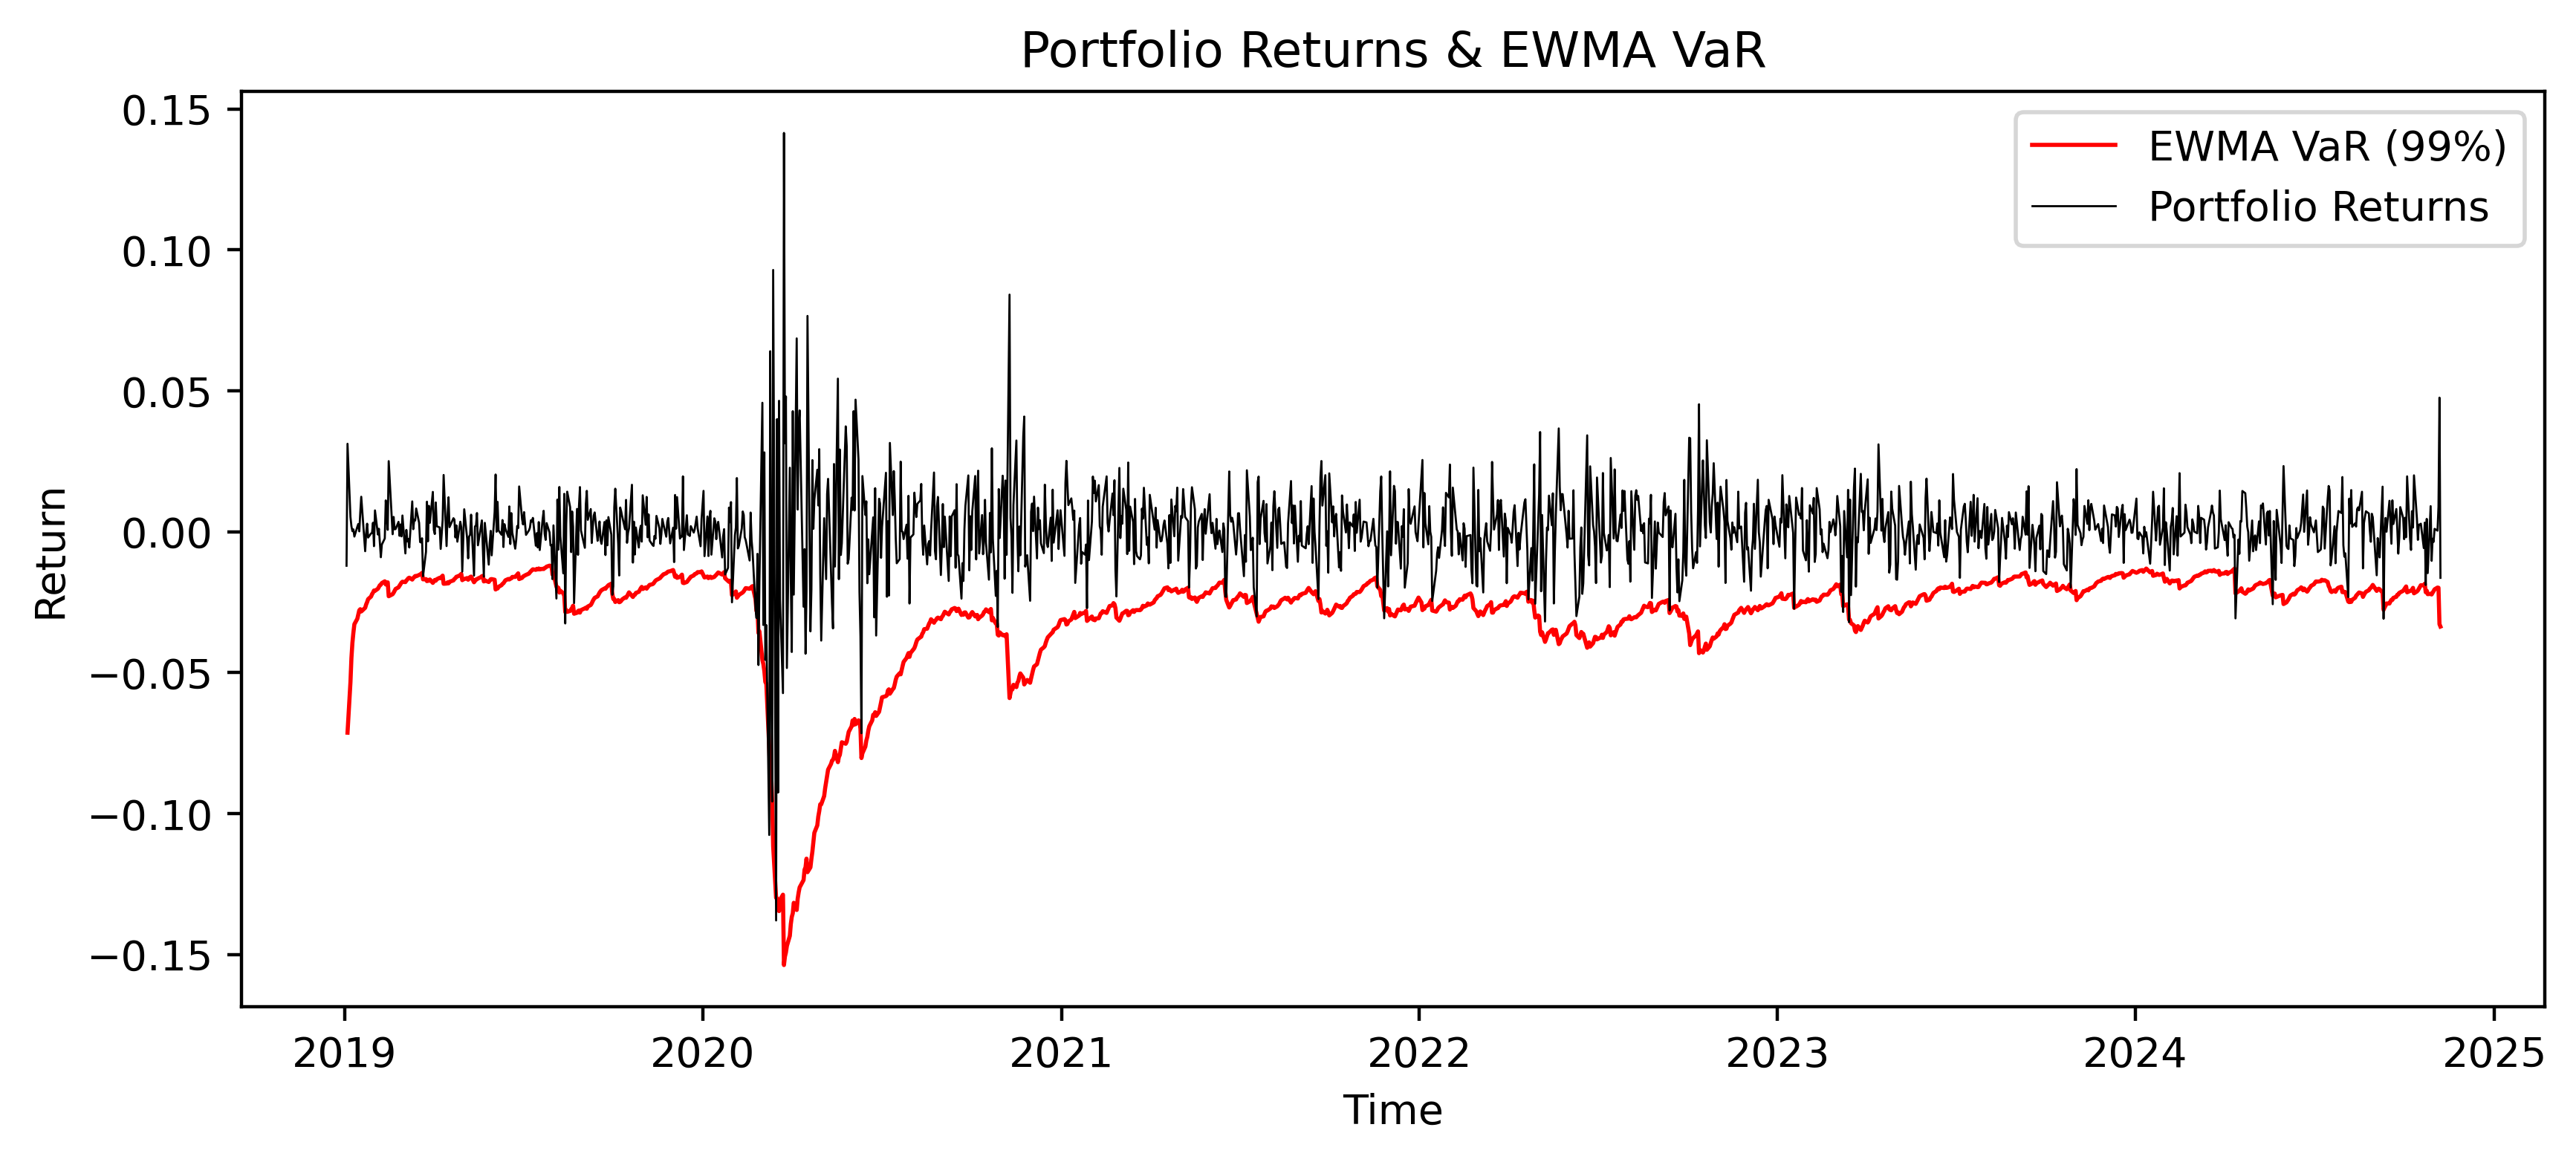

In [100]:
ewma_volatility = portfolio_returns.ewm(span=(2/(1-lambda_))-1, adjust=False).std()

z_score_99 = 2.33  
EWMA_VaR = -z_score_99 * ewma_volatility


plt.figure(figsize=(10, 4), dpi = 400)
plt.plot(EWMA_VaR, label="EWMA VaR (99%)", color='red', linewidth = 1)
plt.plot(portfolio_returns, label="Portfolio Returns", color='black', linewidth = 0.5)

plt.title("Portfolio Returns & EWMA VaR")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

C:\Users\jensen\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.17207331418784e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 25971443345.619263
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1.157163580670888e+19
Iteration:      4,   Func. Count:     43,   Neg. LLF: -4522.629145388377
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4522.629153878475
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4


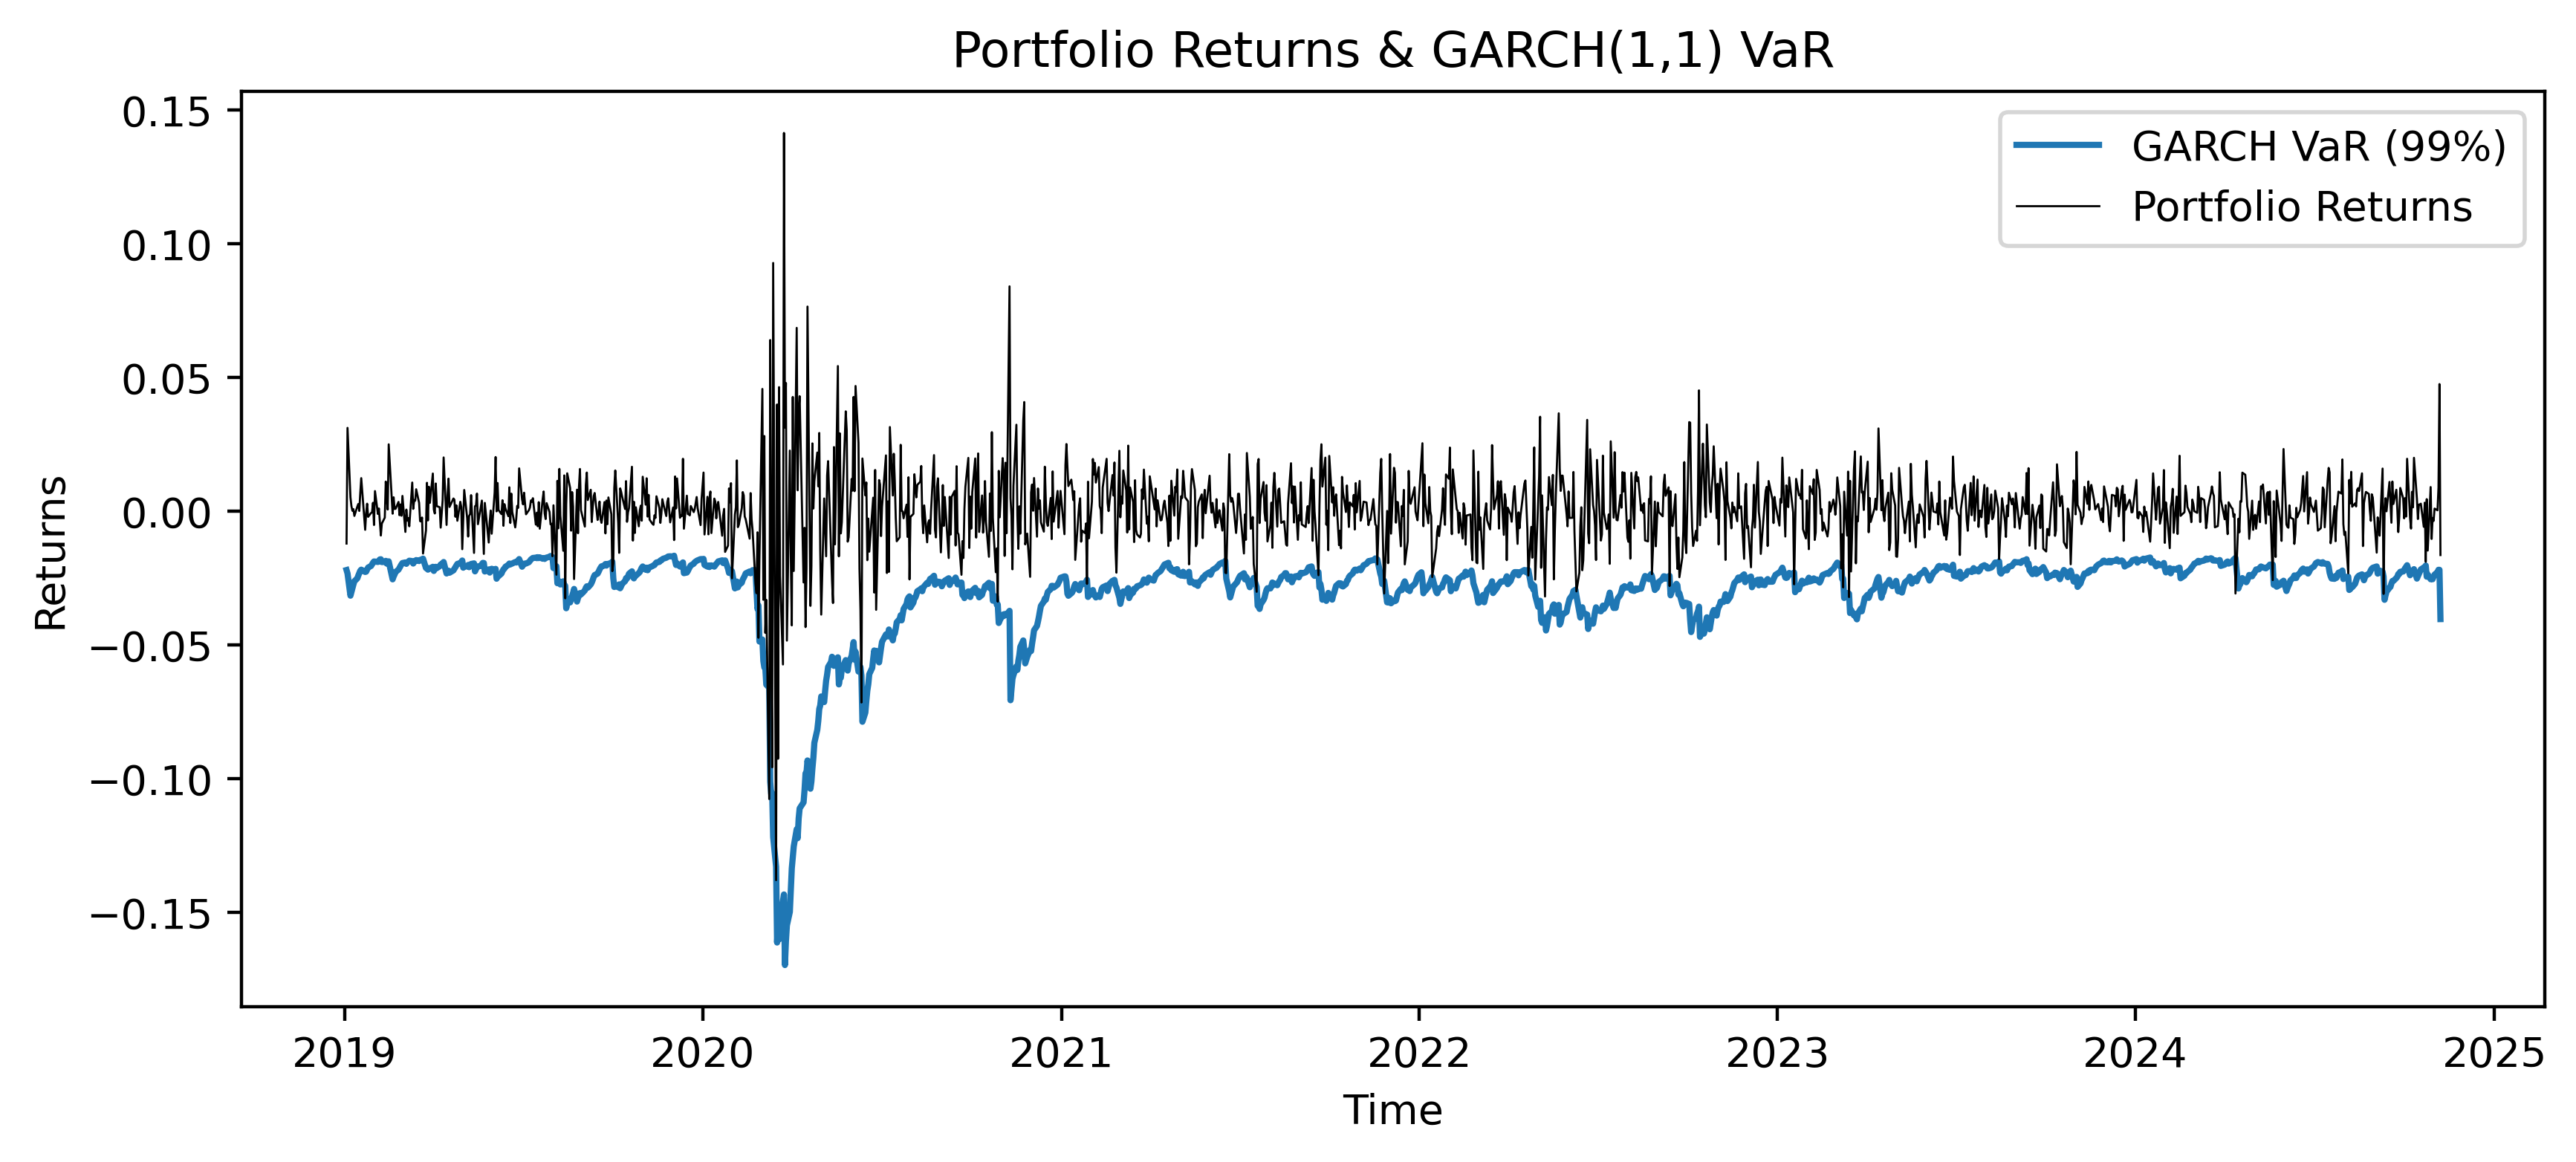

In [101]:
from scipy.stats import norm
from arch import arch_model

model = arch_model(portfolio_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit()
conditional_volatility = garch_fit.conditional_volatility

confidence_level = 0.99
z_score = norm.ppf(confidence_level)
GARCH_VaR = -z_score * conditional_volatility


plt.figure(figsize=(10, 4), dpi = 400)

plt.plot(GARCH_VaR, label='GARCH VaR (99%)')
plt.plot(portfolio_returns, label="Portfolio Returns", color='black', linewidth = 0.5)

plt.title("Portfolio Returns & GARCH(1,1) VaR")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.show()

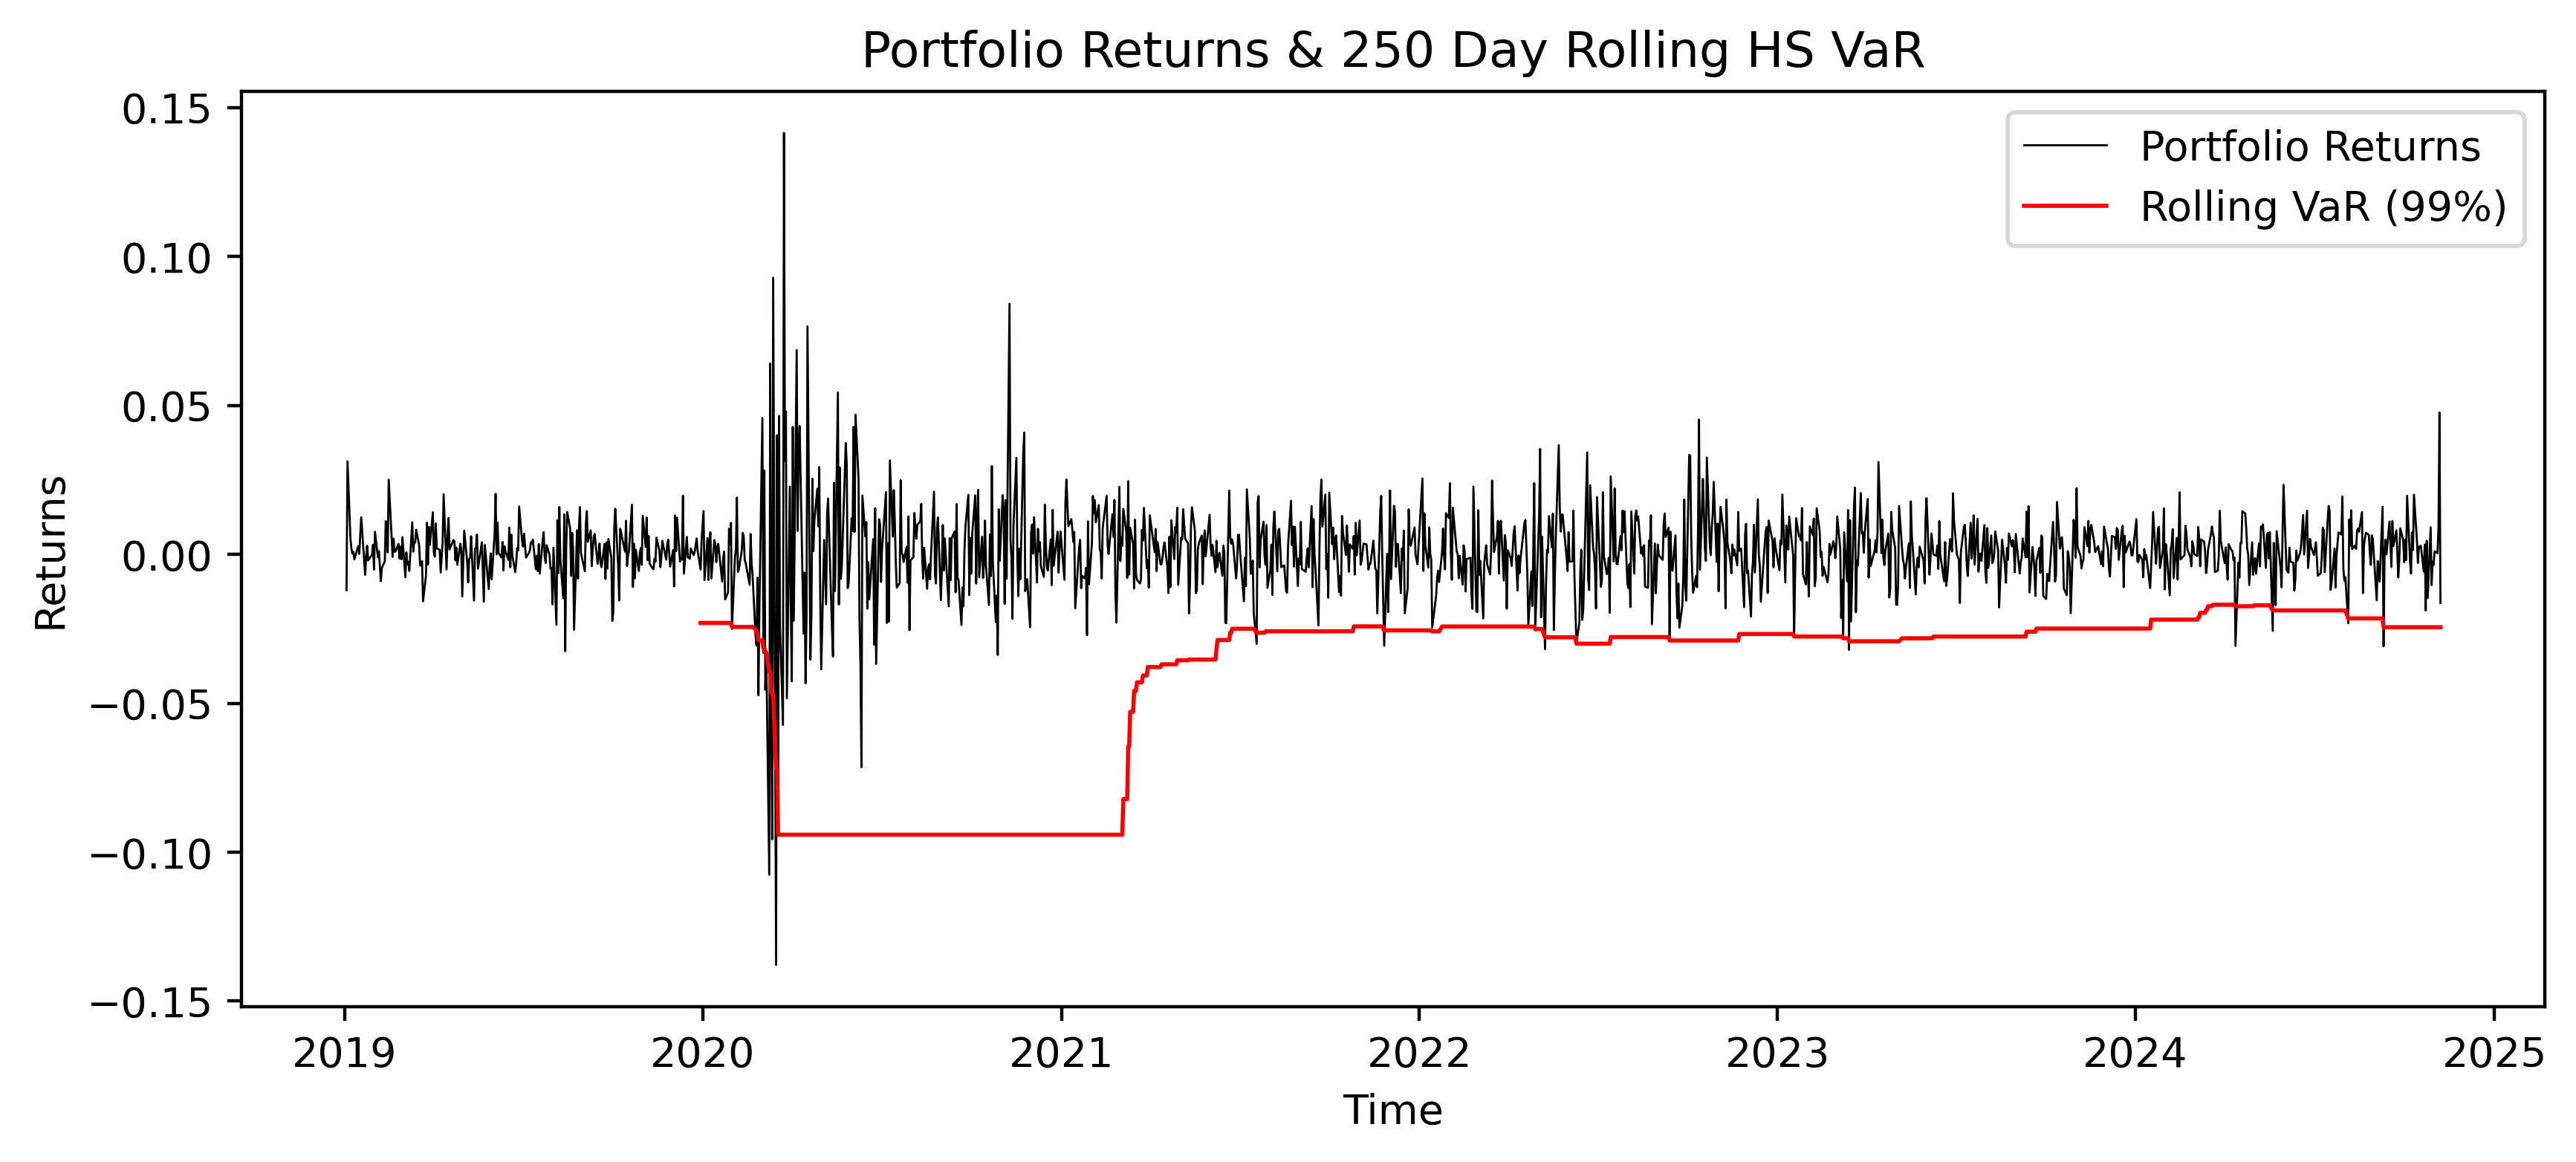

In [107]:
sorted_returns = portfolio_returns.sort_values()

window_size = 250  
confidence_level = 0.01

HS_VaR = portfolio_returns.rolling(window=window_size).apply(
    lambda x: np.percentile(x, confidence_level * 100), raw=False)

plt.figure(figsize=(10, 4), dpi = 400)
plt.plot(portfolio_returns, label="Portfolio Returns", color='black', linewidth = 0.5)
plt.plot(HS_VaR, label="Rolling VaR (99%)", color='red', linewidth = 1)
plt.title("Portfolio Returns & 250 Day Rolling HS VaR")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.show()

,GARCH Violations,HS Violations,EWMA Violations
Date,,,
2019-12-31,3,0,4
2020-12-31,7,11,6
2021-12-31,6,2,4
2022-12-31,3,2,0
2023-12-31,4,2,3
2024-12-31,3,4,3


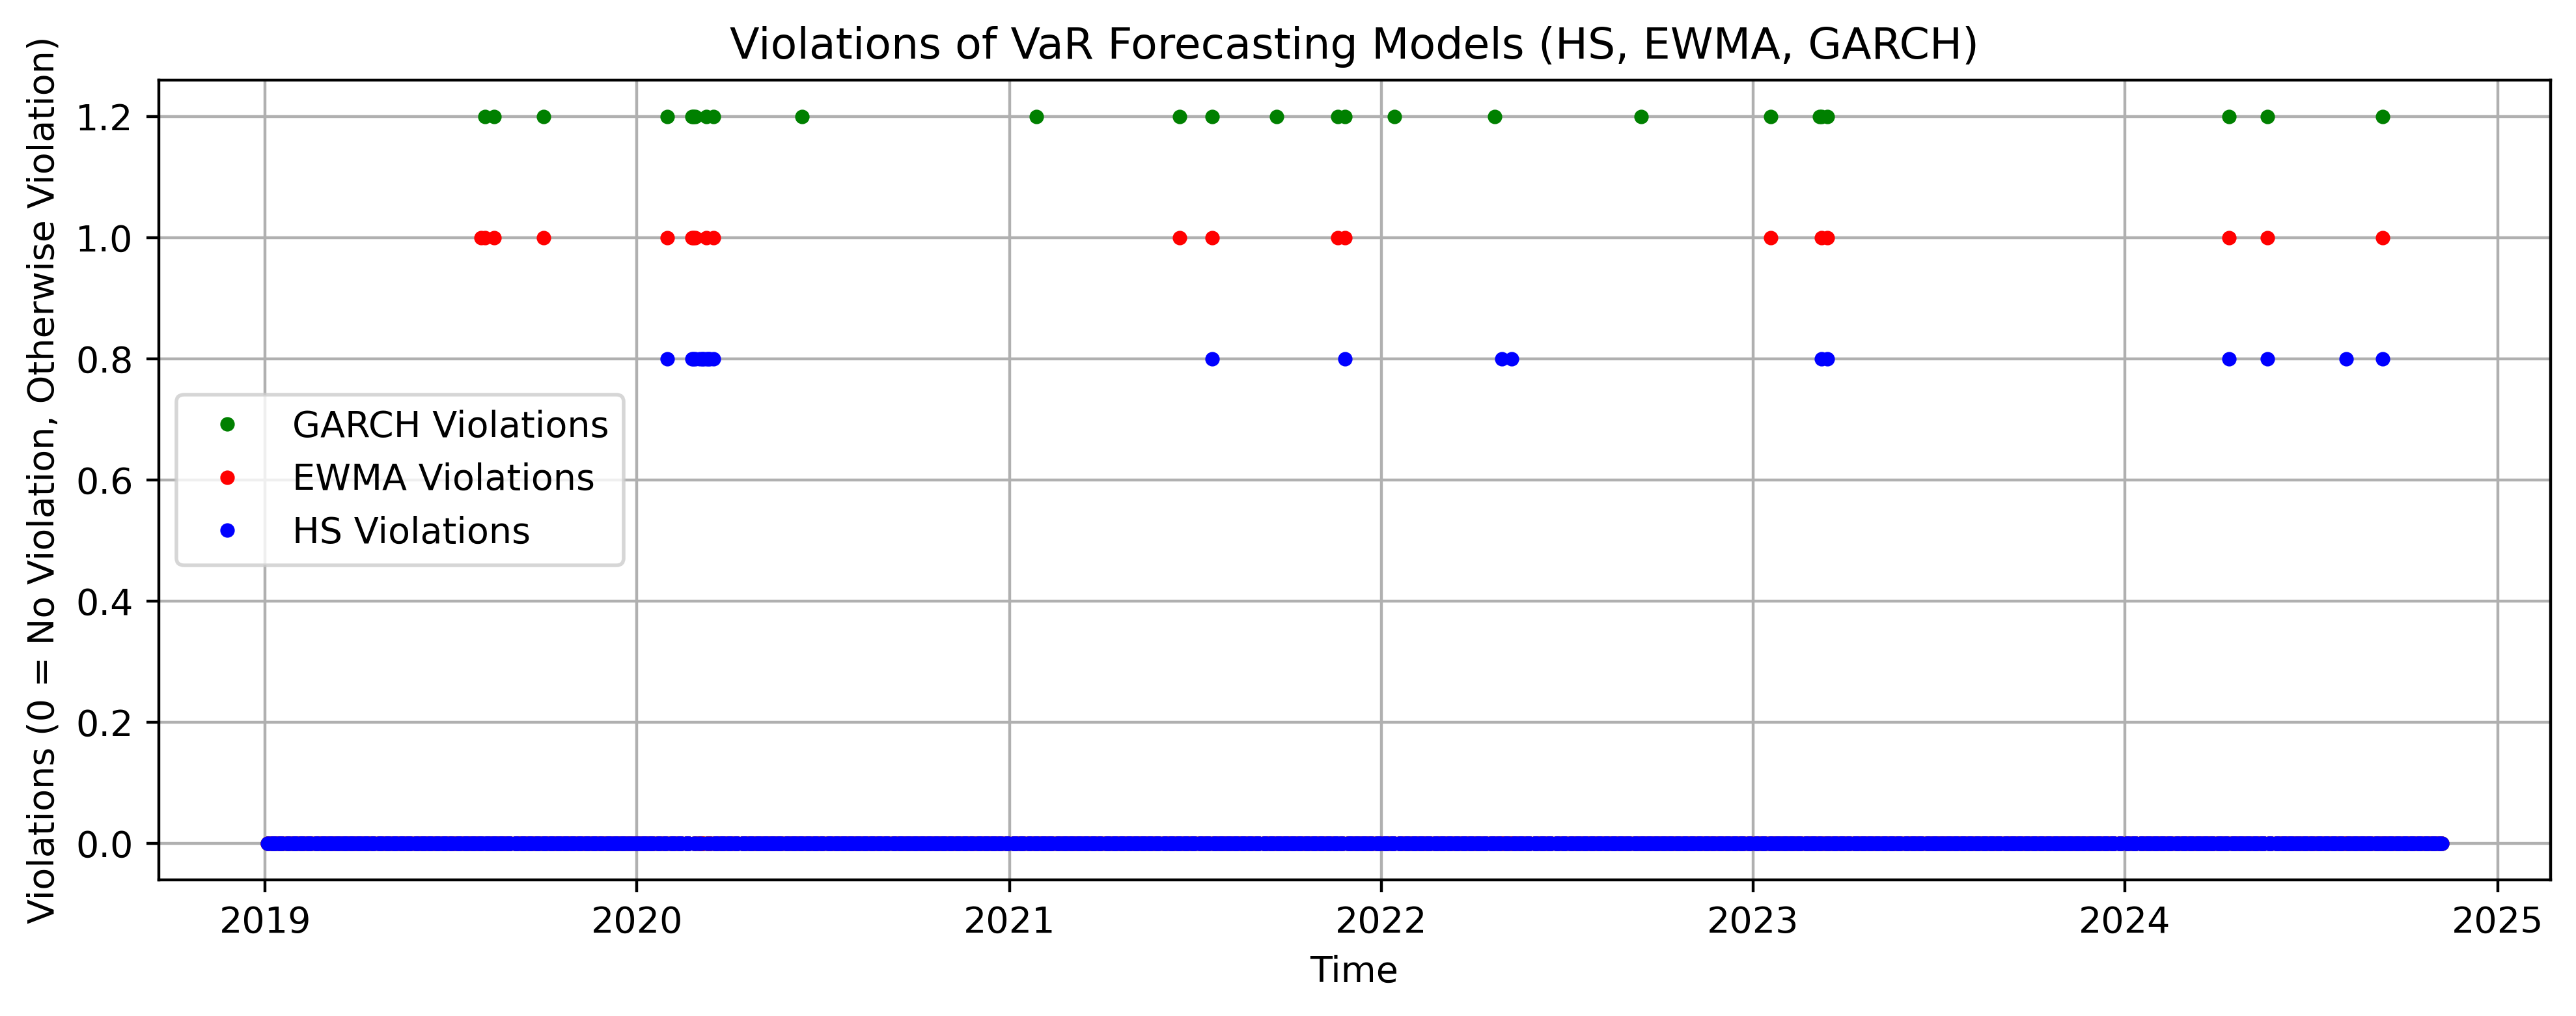

In [149]:
garch_violations = (GARCH_VaR > portfolio_returns).astype(int)
ewma_violations = (EWMA_VaR > portfolio_returns).astype(int)
hs_violations = (HS_VaR > portfolio_returns).astype(int)

garch_violations_df = pd.DataFrame(garch_violations)
hs_violations_df = pd.DataFrame(hs_violations)
ewma_violations_df = pd.DataFrame(ewma_violations)
violations_df = pd.concat([garch_violations_df[0], hs_violations_df['None'], ewma_violations_df['None']], axis=1)

violations_by_year = violations_df.resample('Y').sum()
violations_by_year.columns = ['GARCH Violations', 'HS Violations', 'EWMA Violations']
display(violations_by_year)

plt.figure(figsize=(10, 4), dpi = 400)
plt.plot(garch_violations*1.2, label="GARCH Violations", color='green', marker='o', markersize=3, linestyle='None')
plt.plot(ewma_violations, label="EWMA Violations", color='red', marker='o', markersize=3, linestyle='None')
plt.plot(hs_violations*0.8, label="HS Violations", color='blue', marker='o', markersize=3, linestyle='None')

plt.title("Violations of VaR Forecasting Models (HS, EWMA, GARCH)")
plt.xlabel("Time")
plt.ylabel("Violations (0 = No Violation, Otherwise Violation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [148]:
trading_days = 250
confidence = 0.01

violations_by_year['GARCH Violation Ratio'] = violations_by_year['GARCH Violations'] / (trading_days*confidence)
violations_by_year['HS Violation Ratio'] = violations_by_year['HS Violations'] / (trading_days*confidence)
violations_by_year['EWMA Violation Ratio'] = violations_by_year['EWMA Violations'] / (trading_days*confidence)
violations_by_year

,GARCH Violations,HS Violations,EWMA Violations,GARCH Violation Ratio,HS Violation Ratio,EWMA Violation Ratio
Date,,,,,,
2019-12-31,3,0,4,1.2,0.0,1.6
2020-12-31,7,11,6,2.8,4.4,2.4
2021-12-31,6,2,4,2.4,0.8,1.6
2022-12-31,3,2,0,1.2,0.8,0.0
2023-12-31,4,2,3,1.6,0.8,1.2
2024-12-31,3,4,3,1.2,1.6,1.2


In [151]:
price_data.to_csv('Price_Data.csv', index=False)